In [1]:
# Environment setup and imports
import sys
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, log_loss, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import yaml
from typing import List, Dict

ROOT = Path().resolve().parents[2]  # project root
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

from src.data.real_data import CriteoDataset, SyntheticCriteoDataset
from src.models.esmm import ESMM
from src.models.gbdt_proto import MTGBDT
from src.models.stgbdt import STGBDTBaseline
from src.models.utils import add_cvr_labels


def evaluate_predictions(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """Compute CTR/CTCVR/CVR AUC and LogLoss."""
    eps = 1e-8
    y_click = y_true[:, 0]
    y_conv = y_true[:, 1]
    y_ctcvr = y_click * y_conv

    pred_ctr = np.clip(y_pred[:, 0], eps, 1 - eps)
    pred_ctcvr = np.clip(y_pred[:, 1], eps, 1 - eps)
    pred_cvr = np.clip(y_pred[:, 2], eps, 1 - eps)

    metrics = {}
    metrics["auc_ctr"] = roc_auc_score(y_click, pred_ctr)
    metrics["logloss_ctr"] = log_loss(y_click, pred_ctr)
    precision, recall, thresholds = precision_recall_curve(y_click, pred_ctr)
    metrics["pr_auc_ctr"] = auc(recall, precision)

    metrics["auc_ctcvr"] = roc_auc_score(y_ctcvr, pred_ctcvr)
    metrics["logloss_ctcvr"] = log_loss(y_ctcvr, pred_ctcvr)
    precision, recall, thresholds = precision_recall_curve(y_ctcvr, pred_ctcvr)
    metrics["pr_auc_ctcvr"] = auc(recall, precision)

    click_mask = y_click == 1
    if np.sum(click_mask) > 1 and np.unique(y_conv[click_mask]).size > 1:
        metrics["auc_cvr"] = roc_auc_score(y_conv[click_mask], pred_cvr[click_mask])
        metrics["logloss_cvr"] = log_loss(y_conv[click_mask], pred_cvr[click_mask])
        precision, recall, thresholds = precision_recall_curve(y_conv[click_mask], pred_cvr[click_mask])
        metrics["pr_auc_cvr"] = auc(recall, precision)
    else:
        metrics["auc_cvr"] = np.nan
        metrics["logloss_cvr"] = np.nan
    return metrics

c:\Users\oiwal\products\MT_AI_GBDT\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Configure paths and parameter
def get_data(train_size: int, test_size: int, val_size: int):
    sample_size = train_size + test_size + val_size
    seed = 42
    output_csv = ROOT / "reports" / "tables" / "criteo_experiment_notebook.csv"
    results = []

    # Load Criteo or Synthetic dataset
    data_path = ROOT / "src" / "data" / "criteo-research-uplift-v2.1.csv.gz"
    dataset = CriteoDataset(sample_size=sample_size)
    try:
        X, y = dataset.get_data(random_state=seed)
        source = "CriteoDataset"
    except Exception:
        synth = SyntheticCriteoDataset(sample_size=sample_size)
        X, y = synth.load_data(random_state=seed)
        source = "SyntheticCriteoDataset"

    X_shape, y_shape = X.shape, y.shape

    # Random permutation without overlap
    rng = np.random.default_rng(seed)
    perm = rng.permutation(X.shape[0])
    if len(perm) < sample_size:
        raise ValueError(f"Requested {sample_size} samples but only {len(perm)} available")

    train_idx = perm[:train_size]
    val_idx = perm[train_size:train_size + val_size]
    test_idx = perm[train_size + val_size:train_size + val_size + test_size]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_idx], y[test_idx]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
train_size=100000
val_size=30000
test_size=100000

X_train, X_val, X_test, y_train, y_val, y_test = get_data(train_size=train_size, val_size=val_size, test_size=test_size)
results = []

Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 100000 samples with 16 columns
Data shape: X=(100000, 12), y=(100000, 2)


In [11]:
def do_esmm(X_train, X_val, X_test, y_train, y_val, y_test, results):
    # ESMM
    esmm = ESMM(epochs=5, batch_size=256, verbose=0, validation_split=0.0)
    esmm.fit(X_train, y_train)
    esmm_pred = esmm.predict_proba(X_test)
    esmm_metrics = evaluate_predictions(y_test, esmm_pred)
    esmm_metrics.update({"model": "ESMM", "train_size": train_size})
    esmm_metrics
    results.append(esmm_metrics)

def do_mtgbm(X_train, X_val, X_test, y_train, y_val, y_test, results):
    mtgbdt = MTGBDT(
        n_estimators=20, learning_rate=0.1, max_depth=3, n_tasks=3, loss="logloss", weighting_strategy="mtgbm"
    )
    mtgbdt.fit(X_train, y_train)
    mtgbdt_pred = mtgbdt.predict_proba(X_test)
    mtgbdt_metrics = evaluate_predictions(y_test, mtgbdt_pred)
    mtgbdt_metrics.update({"model": "mtgbm", "train_size": train_size})
    mtgbdt_metrics
    results.append(mtgbdt_metrics)

def do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=0.01):
    mtgbdt = MTGBDT(
        n_estimators=20, learning_rate=0.1, max_depth=3, n_tasks=3, loss="logloss", weighting_strategy="ctcvr_subctr_de_norm_gain"
    )
    mtgbdt.fit(X_train, y_train)
    mtgbdt_pred = mtgbdt.predict_proba(X_test)
    mtgbdt_metrics = evaluate_predictions(y_test, mtgbdt_pred)
    mtgbdt_metrics.update({"model": f"propose_{delta}", "train_size": train_size})
    mtgbdt_metrics
    results.append(mtgbdt_metrics)

def do_propose_kai(X_train, X_val, X_test, y_train, y_val, y_test, results):
    mtgbdt = MTGBDT(
        n_estimators=20, learning_rate=0.1, max_depth=3, n_tasks=3, loss="logloss", weighting_strategy="propose_kai"
    )
    mtgbdt.fit(X_train, y_train)
    mtgbdt_pred = mtgbdt.predict_proba(X_test)
    mtgbdt_metrics = evaluate_predictions(y_test, mtgbdt_pred)
    mtgbdt_metrics.update({"model": "propose_kai", "n_estimators": mtgbdt.n_estimators})
    mtgbdt_metrics
    results.append(mtgbdt_metrics)

def do_stgbdt(X_train, X_val, X_test, y_train, y_val, y_test, results):
    # STGBDT
    stg = STGBDTBaseline(
        n_estimators=20, learning_rate=0.1, max_depth=3, min_samples_split=20, min_samples_leaf=10
    )
    stg.fit(X_train, y_train)
    stg_pred = stg.predict_proba(X_test)
    stg_metrics = evaluate_predictions(y_test, stg_pred)
    stg_metrics.update({"model": "STGBDTBaseline", "train_size": train_size})
    stg_metrics
    results.append(stg_metrics)

In [14]:
# results = []
for train_size in [10000, 50000, 100000]:
    val_size=int(train_size * 0.5)
    test_size=100000
    X_train, X_val, X_test, y_train, y_val, y_test = get_data(train_size=train_size, val_size=val_size, test_size=test_size)
    # do_esmm(X_train, X_val, X_test, y_train, y_val, y_test, results)
    # do_mtgbm(X_train, X_val, X_test, y_train, y_val, y_test, results)
    do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=0.01)
    do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=0.5)
    do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=1)
    do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=5)
    do_propose(X_train, X_val, X_test, y_train, y_val, y_test, results, delta=10)
    # do_propose_kai(X_train, X_val, X_test, y_train, y_val, y_test, results)
    # do_stgbdt(X_train, X_val, X_test, y_train, y_val, y_test, results)

Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-v2.1.csv.gz...
Loaded 115000 samples with 16 columns
Data shape: X=(115000, 12), y=(115000, 2)
Iteration 1/20, LogLoss: 0.068282, Time: 0.20s
Iteration 10/20, LogLoss: 0.054238, Time: 1.93s
Iteration 20/20, LogLoss: 0.044360, Time: 4.46s
Iteration 1/20, LogLoss: 0.068282, Time: 0.19s
Iteration 10/20, LogLoss: 0.054238, Time: 2.02s
Iteration 20/20, LogLoss: 0.044360, Time: 5.77s
Iteration 1/20, LogLoss: 0.068282, Time: 0.39s
Iteration 10/20, LogLoss: 0.054238, Time: 3.43s
Iteration 20/20, LogLoss: 0.044360, Time: 6.30s
Iteration 1/20, LogLoss: 0.068282, Time: 0.18s
Iteration 10/20, LogLoss: 0.054238, Time: 3.47s
Iteration 20/20, LogLoss: 0.044360, Time: 8.24s
Iteration 1/20, LogLoss: 0.068282, Time: 0.30s
Iteration 10/20, LogLoss: 0.054238, Time: 4.66s
Iteration 20/20, LogLoss: 0.044360, Time: 8.82s
Loading Criteo dataset from C:\Users\oiwal\products\MT_AI_GBDT\src\data\criteo-research-uplift-

In [15]:
# Aggregate and display metrics
headers = ["model", "auc_ctr", "auc_ctcvr", "auc_cvr", "logloss_ctr", "logloss_ctcvr", "logloss_cvr"]
print("\n=== Experiment Results ===")
for res in results:
    row = {h: res.get(h, np.nan) for h in headers}
    print(row)

df_results = pd.DataFrame(results)
df_results


=== Experiment Results ===
{'model': 'propose_0.01', 'auc_ctr': 0.9406010476851214, 'auc_ctcvr': 0.8863397537832204, 'auc_cvr': 0.7138695318913829, 'logloss_ctr': 0.07452347047871566, 'logloss_ctcvr': 0.039311047192803136, 'logloss_cvr': 0.45005574181865216}
{'model': 'propose_0.5', 'auc_ctr': 0.9406010476851214, 'auc_ctcvr': 0.8863397537832204, 'auc_cvr': 0.7138695318913829, 'logloss_ctr': 0.07452347047871566, 'logloss_ctcvr': 0.039311047192803136, 'logloss_cvr': 0.45005574181865216}
{'model': 'propose_1', 'auc_ctr': 0.9406010476851214, 'auc_ctcvr': 0.8863397537832204, 'auc_cvr': 0.7138695318913829, 'logloss_ctr': 0.07452347047871566, 'logloss_ctcvr': 0.039311047192803136, 'logloss_cvr': 0.45005574181865216}
{'model': 'propose_5', 'auc_ctr': 0.9406010476851214, 'auc_ctcvr': 0.8863397537832204, 'auc_cvr': 0.7138695318913829, 'logloss_ctr': 0.07452347047871566, 'logloss_ctcvr': 0.039311047192803136, 'logloss_cvr': 0.45005574181865216}
{'model': 'propose_10', 'auc_ctr': 0.94060104768512

,auc_ctr,logloss_ctr,pr_auc_ctr,auc_ctcvr,logloss_ctcvr,pr_auc_ctcvr,auc_cvr,logloss_cvr,pr_auc_cvr,model,train_size
0,0.940601,0.074523,0.388529,0.886340,0.039311,0.123025,0.713870,0.450056,0.406210,propose_0.01,10000
1,0.940601,0.074523,0.388529,0.886340,0.039311,0.123025,0.713870,0.450056,0.406210,propose_0.5,10000
2,0.940601,0.074523,0.388529,0.886340,0.039311,0.123025,0.713870,0.450056,0.406210,propose_1,10000
3,0.940601,0.074523,0.388529,0.886340,0.039311,0.123025,0.713870,0.450056,0.406210,propose_5,10000
4,0.940601,0.074523,0.388529,0.886340,0.039311,0.123025,0.713870,0.450056,0.406210,propose_10,10000
5,0.952116,0.067039,0.455035,0.928254,0.027938,0.172297,0.711090,0.450175,0.400940,propose_0.01,50000
6,0.952116,0.067039,0.455035,0.928254,0.027938,0.172297,0.711090,0.450175,0.400940,propose_0.5,50000
7,0.952116,0.067039,0.455035,0.928254,0.027938,0.172297,0.711090,0.450175,0.400940,propose_1,50000
8,0.952116,0.067039,0.455035,0.928254,0.027938,0.172297,0.711090,0.450175,0.400940,propose_5,50000
9,0.952116,0.067039,0.455035,0.928254,0.027938,0.172297,0.711090,0.450175,0.400940,propose_10,50000


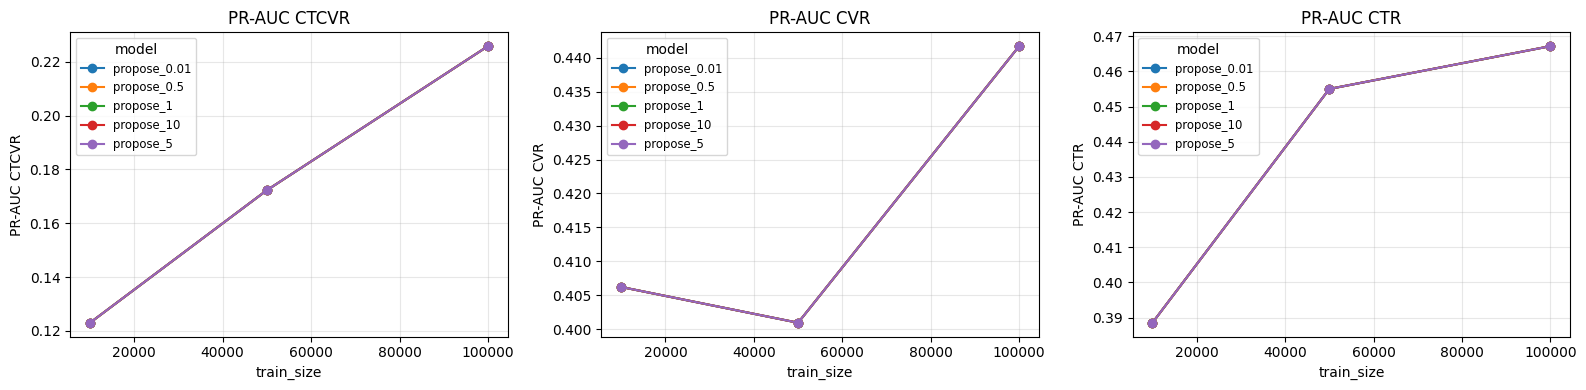

In [16]:
# PR-AUC curves per model vs train_size
import matplotlib.pyplot as plt

metrics = ["pr_auc_ctcvr", "pr_auc_cvr", "pr_auc_ctr"]
metric_labels = {
    "pr_auc_ctcvr": "PR-AUC CTCVR",
    "pr_auc_cvr": "PR-AUC CVR",
    "pr_auc_ctr": "PR-AUC CTR",
}

fig, axes = plt.subplots(1, len(metrics), figsize=(16, 4), sharey=False)
for ax, metric in zip(axes, metrics):
    for model, group in df_results.groupby("model"):
        # Sort by train_size to keep lines monotonic
        plot_df = group.sort_values("train_size")
        ax.plot(
            plot_df["train_size"],
            plot_df[metric],
            marker="o",
            linestyle="-",
            label=model,
        )
    ax.set_title(metric_labels.get(metric, metric))
    ax.set_xlabel("train_size")
    ax.set_ylabel(metric_labels.get(metric, metric))
    ax.grid(True, alpha=0.3)
    ax.legend(title="model", fontsize="small")

plt.tight_layout()
plt.show()